✅ Loaded datasets
Real synthetic data: (2000, 7)
GAN-generated data: (1998, 6)


,patient_id,gene_variant_id,mutation_type,age_of_onset,motor_score,sensory_score,disease_severity
0,P000001,GENE005,nonsense,20,83,88,severe
1,P000002,GENE004,missense,44,61,33,moderate
2,P000003,GENE012,missense,44,73,55,severe
3,P000004,GENE006,frameshift,13,82,77,severe
4,P000005,GENE008,duplication,41,34,39,moderate


,age_of_onset,motor_score,sensory_score,gene_variant_id,mutation_type,disease_severity
0,37,44,37,GENE012,missense,mild
1,41,29,26,GENE002,missense,mild
2,30,39,44,GENE015,frameshift,mild
3,37,58,53,GENE010,nonsense,mild
4,41,60,37,GENE010,nonsense,moderate


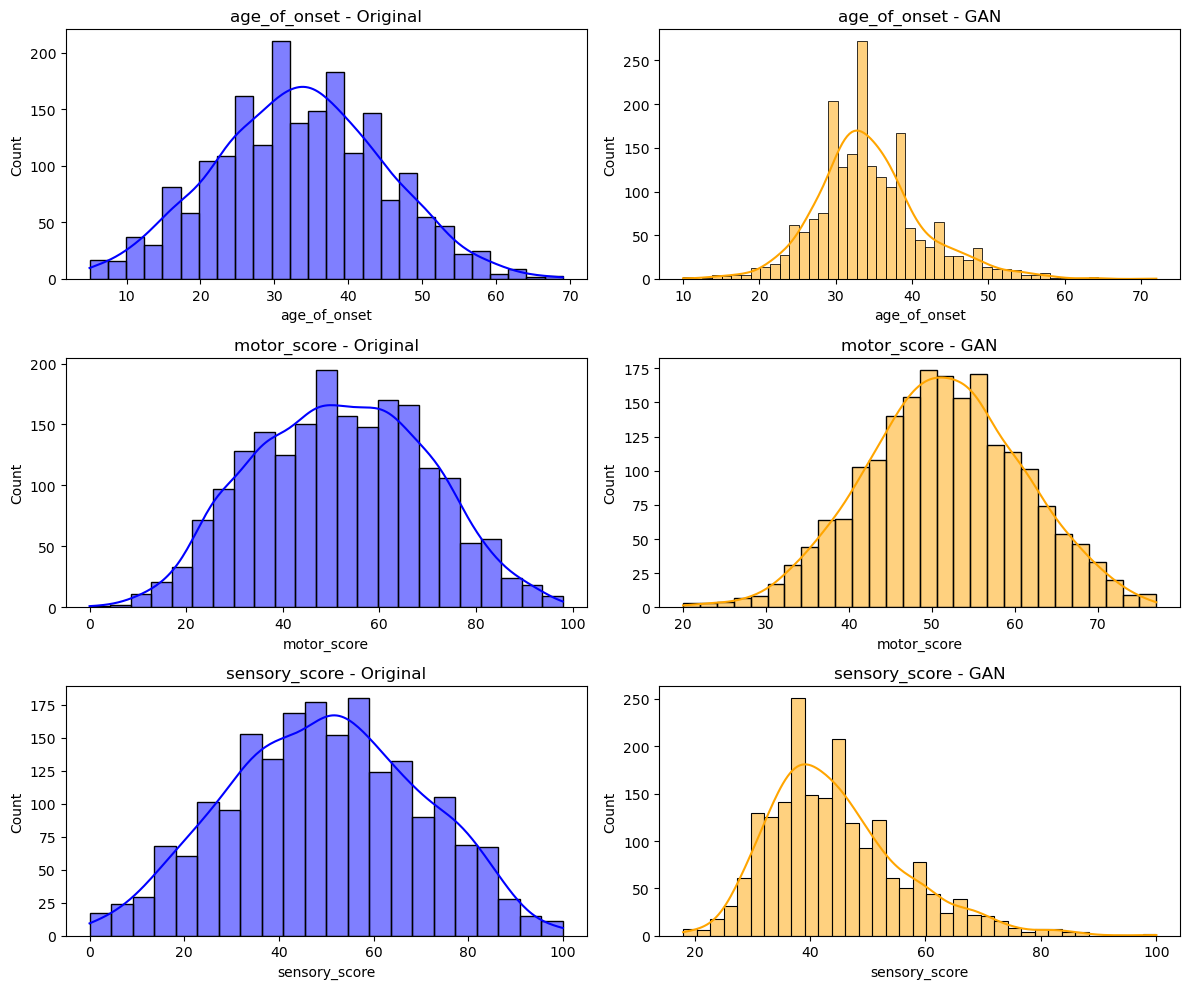


=== Kolmogorov–Smirnov Test Results ===
age_of_onset: KS-stat = 0.1774, p = 0.0000
motor_score: KS-stat = 0.1729, p = 0.0000
sensory_score: KS-stat = 0.2338, p = 0.0000

=== Jensen–Shannon Divergence (Categorical Distributions) ===
gene_variant_id: JS-divergence = 0.2751


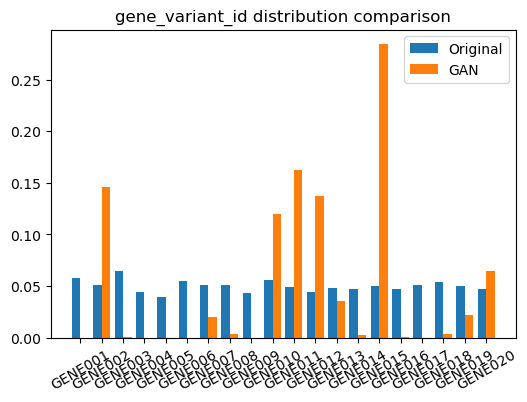

mutation_type: JS-divergence = 0.0323


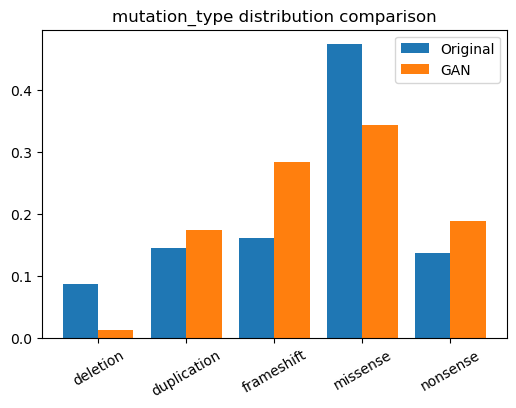

disease_severity: JS-divergence = 0.0229


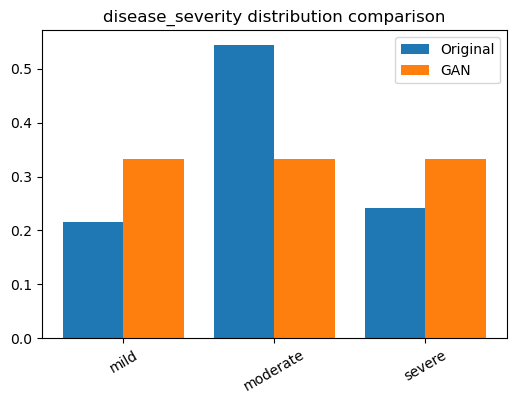

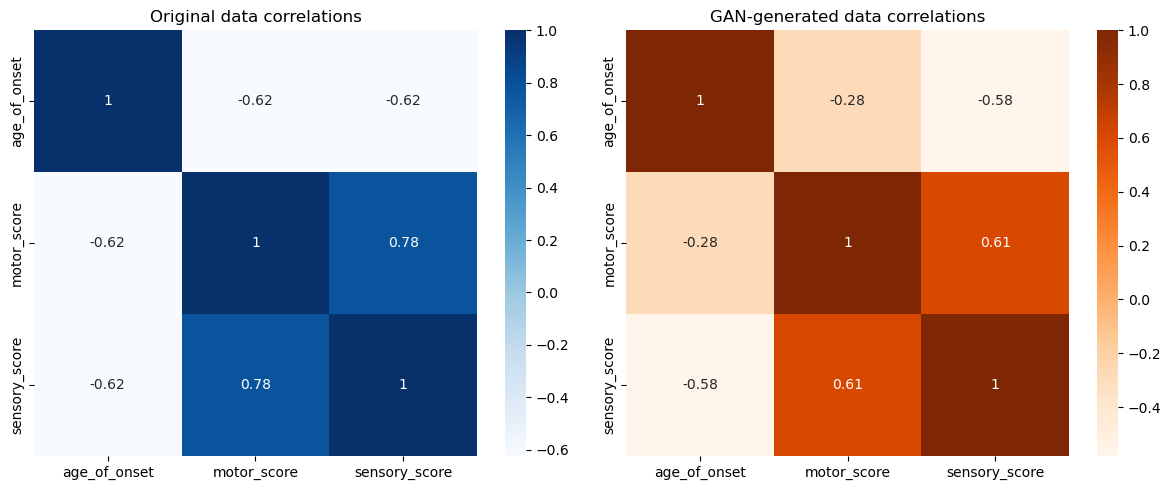

In [2]:
# ============================================
# Evaluation of CGAN Synthetic Data Quality
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, entropy
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# --- Load datasets ---
real_df = pd.read_csv("../data/synthetic/cmt_synthetic_dataset.csv")
gan_df  = pd.read_csv("../data/synthetic/cmt_synthetic_generated.csv")

print("✅ Loaded datasets")
print(f"Real synthetic data: {real_df.shape}")
print(f"GAN-generated data: {gan_df.shape}")

# --- Basic summary ---
display(real_df.head(), gan_df.head())

# ============================================
# 1️⃣ Numeric Distribution Comparison
# ============================================

numeric_cols = ["age_of_onset", "motor_score", "sensory_score"]
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    sns.histplot(real_df[col], color="blue", kde=True, label="Original", ax=axes[i, 0])
    sns.histplot(gan_df[col], color="orange", kde=True, label="GAN", ax=axes[i, 1])
    axes[i, 0].set_title(f"{col} - Original")
    axes[i, 1].set_title(f"{col} - GAN")
plt.tight_layout()
plt.show()

# KS-test for numeric similarity
print("\n=== Kolmogorov–Smirnov Test Results ===")
for col in numeric_cols:
    ks_stat, ks_p = ks_2samp(real_df[col], gan_df[col])
    print(f"{col}: KS-stat = {ks_stat:.4f}, p = {ks_p:.4f}")

# ============================================
# 2️⃣ Categorical Distribution Comparison
# ============================================
categorical_cols = ["gene_variant_id", "mutation_type", "disease_severity"]

def js_divergence(p, q):
    """Compute Jensen–Shannon divergence between two distributions."""
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

print("\n=== Jensen–Shannon Divergence (Categorical Distributions) ===")
for col in categorical_cols:
    real_counts = real_df[col].value_counts(normalize=True).sort_index()
    gan_counts = gan_df[col].value_counts(normalize=True).sort_index()
    # Align categories
    all_cats = sorted(set(real_counts.index) | set(gan_counts.index))
    real_vec = [real_counts.get(c, 0) for c in all_cats]
    gan_vec = [gan_counts.get(c, 0) for c in all_cats]
    jsd = js_divergence(real_vec, gan_vec)
    print(f"{col}: JS-divergence = {jsd:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(6,4))
    x = np.arange(len(all_cats))
    plt.bar(x-0.2, real_vec, 0.4, label='Original')
    plt.bar(x+0.2, gan_vec, 0.4, label='GAN')
    plt.xticks(x, all_cats, rotation=30)
    plt.title(f"{col} distribution comparison")
    plt.legend()
    plt.show()

# ============================================
# 3️⃣ Correlation Structure Comparison
# ============================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(real_df[numeric_cols].corr(), annot=True, cmap="Blues")
plt.title("Original data correlations")

plt.subplot(1, 2, 2)
sns.heatmap(gan_df[numeric_cols].corr(), annot=True, cmap="Oranges")
plt.title("GAN-generated data correlations")
plt.tight_layout()
plt.show()

# ============================================
# 4️⃣ TSTR — Train on Synthetic, Test on Real
# ============================================

def preprocess(df):
    X_num = df[numeric_cols]
    X_cat = df[["gene_variant_id", "mutation_type"]]
    y = df["disease_severity"]

    enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    scaler = StandardScaler()
    
    X_real_num = real_df[numeric_cols]
    X_real_cat = real_df[["gene_variant_id", "mutation_type"]]
    y_real = real_df["disease_severity"]
    
    X_gan_num = gan_df[numeric_cols]
    X_gan_cat = gan_df[["gene_variant_id", "mutation_type"]]
    y_gan = gan_df["disease_severity"]
    
    # Fit on real, transform both
    X_real_cat_enc = enc.fit_transform(X_real_cat)
    X_gan_cat_enc = enc.transform(X_gan_cat)
    
    X_real_num_scaled = scaler.fit_transform(X_real_num)
    X_gan_num_scaled = scaler.transform(X_gan_num)
    
    X_real = np.hstack([X_real_num_scaled, X_real_cat_enc])
    X_gan = np.hstack([X_gan_num_scaled, X_gan_cat_enc])
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train on synthetic (GAN) → Test on real
    rf.fit(X_gan, y_gan)
    y_pred = rf.predict(X_real)
    acc = accuracy_score(y_real, y_pred)
    
    print("\n=== TSTR (Train Synthetic, Test Real) ===")
    print(f"Accuracy (synthetic-trained model tested on real): {acc:.4f}")
    
    # ============================================
    # Optional — Save summary report
    # ============================================
    summary = {
        "num_samples_real": len(real_df),
        "num_samples_gan": len(gan_df),
        "TSTR_accuracy": round(acc, 4)
    }
    print("\nSummary:", summary)
    pd.DataFrame([summary]).to_csv("../results/evaluation_summary.csv", index=False)
    print("✅ Evaluation summary saved to ../results/evaluation_summary.csv")
